# ⚡ Industrial Anomaly Detection Tutorial

## **Machine Learning for Industrial Fault Detection and Process Monitoring**

### **Main Goal:**
Learn to detect anomalies in industrial processes using density estimation methods. This tutorial demonstrates how to identify abnormal operating conditions in manufacturing systems using machine learning techniques on sensor data.

### **Key Learning Objectives:**
- **Anomaly Detection Fundamentals**: Understand normal vs abnormal behavior patterns
- **Density Estimation Methods**: Compare different approaches (Gaussian, GMM, KDE, Isolation Forest, etc.)
- **Industrial Data Processing**: Handle sensor data with noise, drift, and missing values
- **Evaluation Metrics**: Use precision, recall, F1-score, and ROC curves for anomaly detection
- **Threshold Optimization**: Find optimal detection thresholds for industrial applications

### **Industrial Relevance:**
Apply to **predictive maintenance**, **quality control**, **process monitoring**, **equipment failure detection**, and **safety systems** in manufacturing environments.

### **Interactive Features:**
🎮 Multi-algorithm comparison | 📊 Real-time threshold tuning | ⚡ ROC curve analysis | 🔬 Feature importance for anomalies

**Dataset**: Industrial Process Monitoring with 5 critical sensor measurements (Temperature, Pressure, Vibration, Flow Rate, Power Consumption)

---

## 1. Import Required Libraries

We'll use comprehensive ML libraries for anomaly detection, including density estimation and evaluation tools.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import KernelDensity
from scipy import stats
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)
%matplotlib widget

print("Libraries imported successfully!")
print("Ready for industrial anomaly detection tutorial")

Libraries imported successfully!
Ready for industrial anomaly detection tutorial


## 2. Generate Industrial Process Dataset

Let's create a realistic industrial dataset with 5 key sensor measurements representing normal operating conditions and various types of anomalies.

In [2]:
def generate_industrial_data(n_normal=1000, n_anomalies=100, random_state=42):
    """
    Generate realistic industrial process data with 5 sensor measurements:
    - Temperature (°C): Operating temperature of the process
    - Pressure (Bar): System pressure
    - Vibration (mm/s): Equipment vibration levels
    - Flow_Rate (L/min): Process flow rate
    - Power_Consumption (kW): Energy consumption
    """
    np.random.seed(random_state)
    
    # Define normal operating ranges and correlations
    normal_means = np.array([75.0, 2.5, 1.2, 150.0, 45.0])  # Normal operating points
    
    # Correlation matrix - realistic industrial relationships
    # Temperature correlates with power, pressure affects flow rate, etc.
    correlation_matrix = np.array([
        [1.0,  0.3,  0.1,  0.2,  0.7],  # Temperature
        [0.3,  1.0,  0.4, -0.6,  0.2],  # Pressure
        [0.1,  0.4,  1.0,  0.1,  0.3],  # Vibration
        [0.2, -0.6,  0.1,  1.0, -0.1],  # Flow Rate
        [0.7,  0.2,  0.3, -0.1,  1.0]   # Power Consumption
    ])
    
    # Standard deviations for normal operation
    normal_stds = np.array([3.0, 0.2, 0.15, 10.0, 5.0])
    
    # Create covariance matrix
    normal_cov = np.outer(normal_stds, normal_stds) * correlation_matrix
    
    # Generate normal data
    normal_data = np.random.multivariate_normal(normal_means, normal_cov, n_normal)
    
    # Ensure realistic physical constraints
    normal_data[:, 0] = np.clip(normal_data[:, 0], 60, 90)    # Temperature range
    normal_data[:, 1] = np.clip(normal_data[:, 1], 1.5, 4.0) # Pressure range
    normal_data[:, 2] = np.clip(normal_data[:, 2], 0.5, 2.5) # Vibration range
    normal_data[:, 3] = np.clip(normal_data[:, 3], 120, 200) # Flow rate range
    normal_data[:, 4] = np.clip(normal_data[:, 4], 30, 65)   # Power range
    
    # Generate different types of anomalies
    anomalies = []
    anomaly_types = []
    
    # Type 1: Equipment overheating (high temperature, high power)
    n_overheat = n_anomalies // 5
    overheat_data = np.random.multivariate_normal(
        [95, 2.8, 1.5, 140, 70], 
        np.diag([4, 0.3, 0.2, 15, 8])**2, 
        n_overheat
    )
    anomalies.append(overheat_data)
    anomaly_types.extend(['Overheating'] * n_overheat)
    
    # Type 2: Pressure surge (high pressure, reduced flow)
    n_pressure = n_anomalies // 5
    pressure_data = np.random.multivariate_normal(
        [78, 4.2, 2.0, 100, 50], 
        np.diag([2, 0.4, 0.3, 12, 6])**2, 
        n_pressure
    )
    anomalies.append(pressure_data)
    anomaly_types.extend(['Pressure_Surge'] * n_pressure)
    
    # Type 3: Excessive vibration (equipment wear)
    n_vibration = n_anomalies // 5
    vibration_data = np.random.multivariate_normal(
        [73, 2.6, 3.5, 155, 48], 
        np.diag([3, 0.2, 0.4, 8, 5])**2, 
        n_vibration
    )
    anomalies.append(vibration_data)
    anomaly_types.extend(['Excessive_Vibration'] * n_vibration)
    
    # Type 4: Flow blockage (low flow, high pressure)
    n_blockage = n_anomalies // 5
    blockage_data = np.random.multivariate_normal(
        [77, 3.5, 1.8, 80, 42], 
        np.diag([2, 0.3, 0.2, 10, 4])**2, 
        n_blockage
    )
    anomalies.append(blockage_data)
    anomaly_types.extend(['Flow_Blockage'] * n_blockage)
    
    # Type 5: Power anomaly (erratic power consumption)
    n_power = n_anomalies - (n_overheat + n_pressure + n_vibration + n_blockage)
    power_data = np.random.multivariate_normal(
        [74, 2.4, 1.3, 148, 25], 
        np.diag([5, 0.4, 0.3, 20, 10])**2, 
        n_power
    )
    anomalies.append(power_data)
    anomaly_types.extend(['Power_Anomaly'] * n_power)
    
    # Combine all anomalies
    anomaly_data = np.vstack(anomalies)
    
    # Create combined dataset
    X = np.vstack([normal_data, anomaly_data])
    y = np.hstack([np.zeros(n_normal), np.ones(n_anomalies)])  # 0 = normal, 1 = anomaly
    
    # Create detailed labels
    detailed_labels = ['Normal'] * n_normal + anomaly_types
    
    # Feature names
    feature_names = ['Temperature_C', 'Pressure_Bar', 'Vibration_mm_s', 'Flow_Rate_L_min', 'Power_Consumption_kW']
    
    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df['is_anomaly'] = y
    df['anomaly_type'] = detailed_labels
    
    return df, X, y, feature_names

# Generate the dataset
print("Generating Industrial Process Dataset...")
df, X, y, feature_names = generate_industrial_data(n_normal=1000, n_anomalies=100)

print(f"Dataset created successfully!")
print(f"Total samples: {len(df)}")
print(f"Normal samples: {(y == 0).sum()}")
print(f"Anomalous samples: {(y == 1).sum()}")
print(f"Anomaly rate: {(y == 1).mean()*100:.1f}%")
print(f"Features: {feature_names}")

print("\nFirst 5 rows:")
display(df.head())

print("\nDataset statistics:")
display(df[feature_names].describe())

print("\nAnomaly type distribution:")
print(df['anomaly_type'].value_counts())

Generating Industrial Process Dataset...
Dataset created successfully!
Total samples: 1100
Normal samples: 1000
Anomalous samples: 100
Anomaly rate: 9.1%
Features: ['Temperature_C', 'Pressure_Bar', 'Vibration_mm_s', 'Flow_Rate_L_min', 'Power_Consumption_kW']

First 5 rows:


,Temperature_C,Pressure_Bar,Vibration_mm_s,Flow_Rate_L_min,Power_Consumption_kW,is_anomaly,anomaly_type
0,76.088520,2.433845,0.972490,144.960690,45.447197,0.0,Normal
1,72.454332,2.549394,1.157290,152.015501,36.509865,0.0,Normal
2,76.805802,2.668412,1.519417,154.666292,46.818215,0.0,Normal
3,78.334865,2.573501,1.396083,155.719579,49.385207,0.0,Normal
4,74.800010,2.847338,1.393261,135.370147,46.900784,0.0,Normal



Dataset statistics:


,Temperature_C,Pressure_Bar,Vibration_mm_s,Flow_Rate_L_min,Power_Consumption_kW
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,75.442990,2.551714,1.271385,147.779015,45.204783
std,4.112828,0.321689,0.361188,15.451149,6.936909
min,64.120184,1.522247,0.584708,65.025533,9.684647
25%,73.058615,2.375271,1.107854,142.534613,41.415014
50%,75.265000,2.517152,1.211337,149.113118,45.316356
75%,77.304929,2.662246,1.328111,156.381209,48.734413
max,103.168712,4.498645,3.827749,187.196745,87.480759



Anomaly type distribution:
anomaly_type
Normal                 1000
Overheating              20
Pressure_Surge           20
Excessive_Vibration      20
Flow_Blockage            20
Power_Anomaly            20
Name: count, dtype: int64


## 3. Data Exploration and Visualization

Let's explore the dataset to understand the characteristics of normal operation and different types of anomalies.

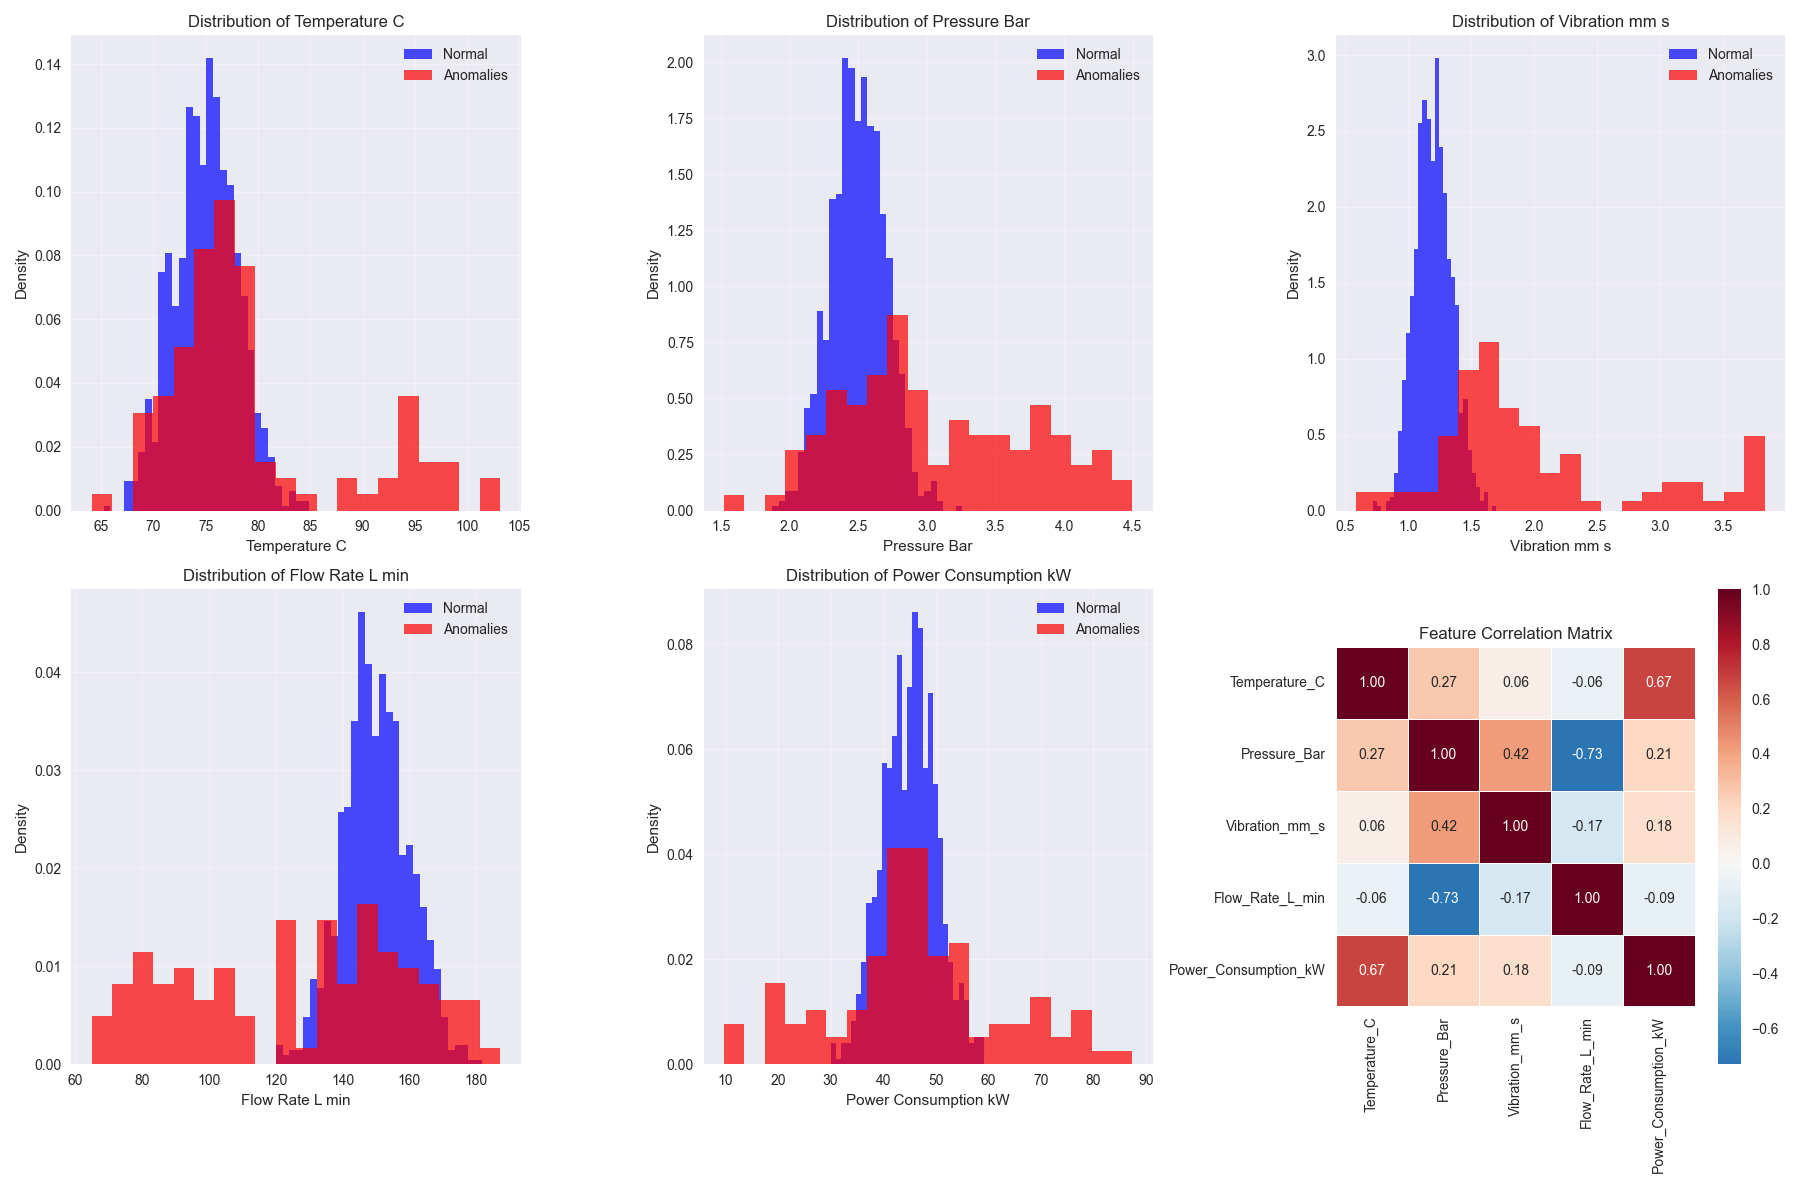

KEY OBSERVATIONS:
✅ Normal data shows consistent operating ranges
❌ Anomalies deviate significantly in specific features
🔗 Features show realistic industrial correlations
📊 Different anomaly types have distinct signatures


In [3]:
# Visualize the dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Individual feature distributions
for i, feature in enumerate(feature_names):
    ax = axes[i]
    
    # Plot normal data
    normal_data = df[df['is_anomaly'] == 0][feature]
    anomaly_data = df[df['is_anomaly'] == 1][feature]
    
    ax.hist(normal_data, bins=30, alpha=0.7, label='Normal', color='blue', density=True)
    ax.hist(anomaly_data, bins=20, alpha=0.7, label='Anomalies', color='red', density=True)
    
    ax.set_xlabel(feature.replace('_', ' '))
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {feature.replace("_", " ")}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Correlation heatmap
ax = axes[5]
correlation_matrix = df[feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

print("KEY OBSERVATIONS:")
print("=" * 50)
print("✅ Normal data shows consistent operating ranges")
print("❌ Anomalies deviate significantly in specific features")
print("🔗 Features show realistic industrial correlations")
print("📊 Different anomaly types have distinct signatures")

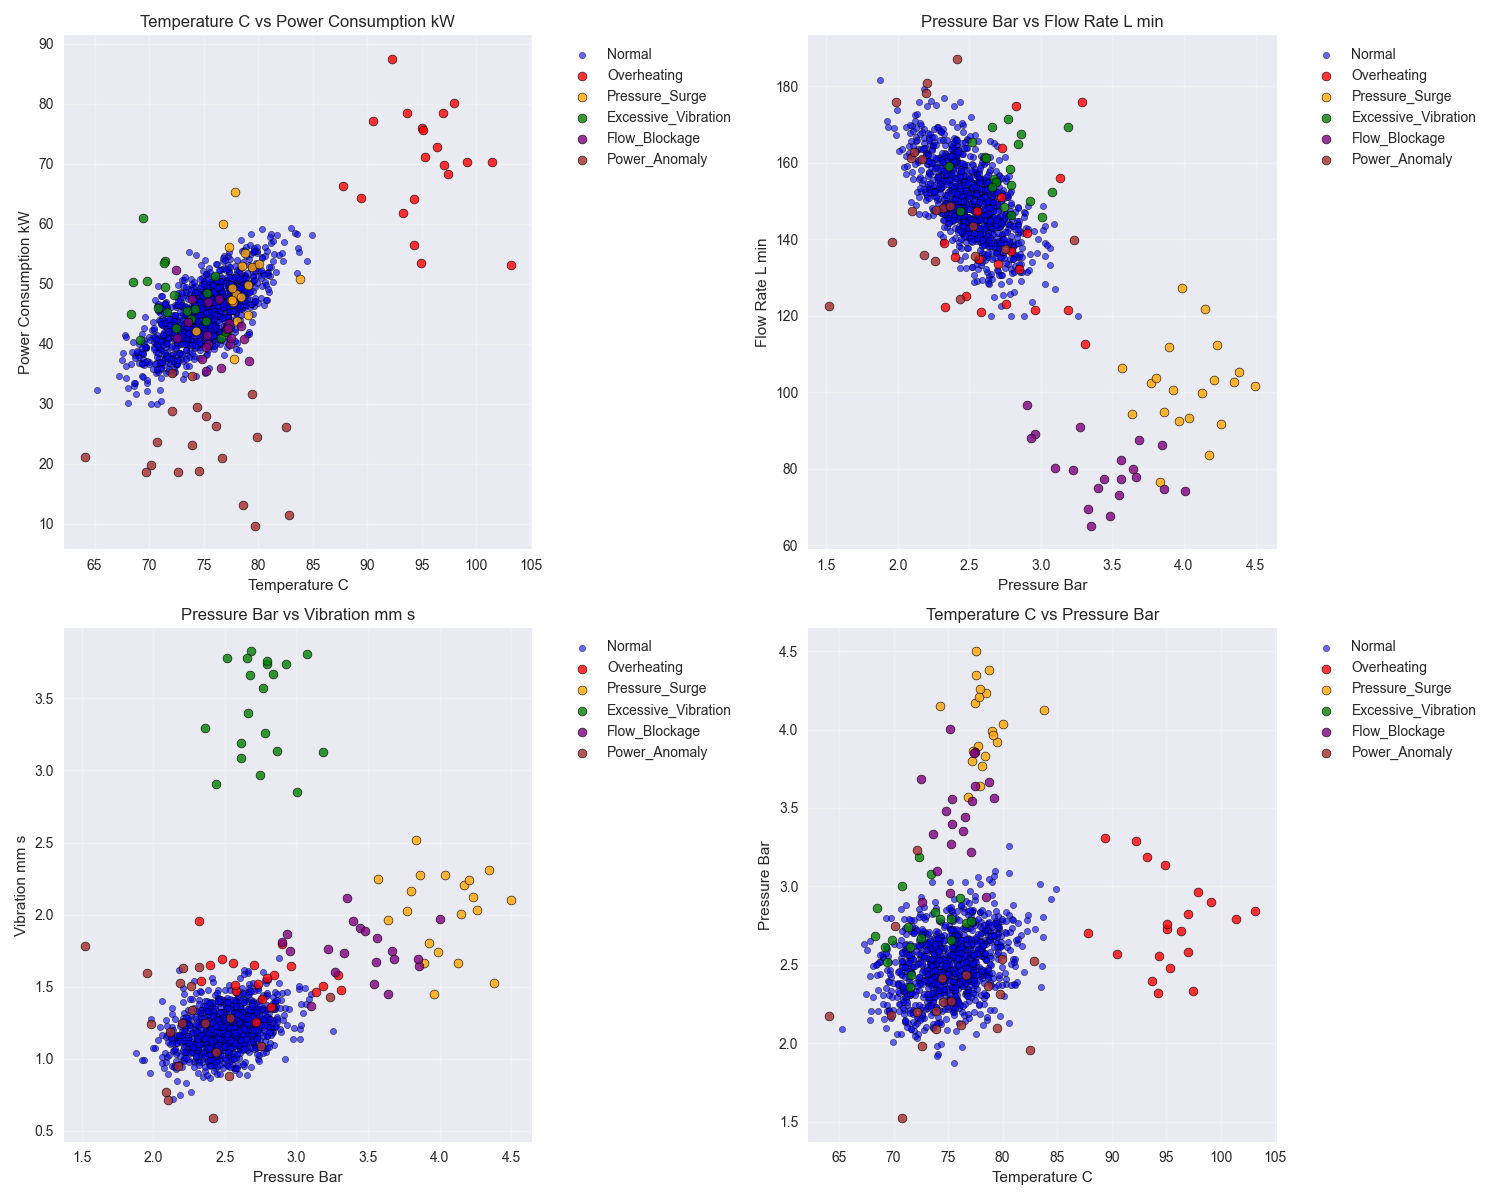

ANOMALY PATTERN ANALYSIS:
🔥 Overheating: High temperature + high power consumption
💨 Pressure Surge: High pressure + reduced flow rate
📳 Excessive Vibration: High vibration levels across conditions
🚫 Flow Blockage: Low flow rate + increased pressure
⚡ Power Anomaly: Unusual power consumption patterns


In [4]:
# Pairwise scatter plots to visualize anomaly patterns
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# Select most interesting feature pairs
feature_pairs = [
    (0, 4),  # Temperature vs Power
    (1, 3),  # Pressure vs Flow Rate
    (1, 2),  # Pressure vs Vibration
    (0, 1)   # Temperature vs Pressure
]

colors = {'Normal': 'blue', 'Overheating': 'red', 'Pressure_Surge': 'orange', 
          'Excessive_Vibration': 'green', 'Flow_Blockage': 'purple', 'Power_Anomaly': 'brown'}

for idx, (i, j) in enumerate(feature_pairs):
    ax = axes[idx//2, idx%2]
    
    for anomaly_type in df['anomaly_type'].unique():
        mask = df['anomaly_type'] == anomaly_type
        data_subset = df[mask]
        
        alpha = 0.6 if anomaly_type == 'Normal' else 0.8
        size = 20 if anomaly_type == 'Normal' else 40
        
        ax.scatter(data_subset.iloc[:, i], data_subset.iloc[:, j],
                  c=colors[anomaly_type], label=anomaly_type, 
                  alpha=alpha, s=size, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(feature_names[i].replace('_', ' '))
    ax.set_ylabel(feature_names[j].replace('_', ' '))
    ax.set_title(f'{feature_names[i].replace("_", " ")} vs {feature_names[j].replace("_", " ")}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ANOMALY PATTERN ANALYSIS:")
print("=" * 50)
print("🔥 Overheating: High temperature + high power consumption")
print("💨 Pressure Surge: High pressure + reduced flow rate")
print("📳 Excessive Vibration: High vibration levels across conditions")
print("🚫 Flow Blockage: Low flow rate + increased pressure")
print("⚡ Power Anomaly: Unusual power consumption patterns")

In [5]:
# Statistical analysis of normal vs anomalous data
print("STATISTICAL COMPARISON: NORMAL vs ANOMALOUS DATA")
print("=" * 70)

normal_stats = df[df['is_anomaly'] == 0][feature_names].describe()
anomaly_stats = df[df['is_anomaly'] == 1][feature_names].describe()

print("\nNORMAL OPERATION STATISTICS:")
print("-" * 40)
display(normal_stats)

print("\nANOMALY STATISTICS:")
print("-" * 40)
display(anomaly_stats)

# Calculate separation metrics
print("\nFEATURE SEPARABILITY ANALYSIS:")
print("-" * 40)

for feature in feature_names:
    normal_values = df[df['is_anomaly'] == 0][feature]
    anomaly_values = df[df['is_anomaly'] == 1][feature]
    
    # Calculate means and standard deviations
    normal_mean, normal_std = normal_values.mean(), normal_values.std()
    anomaly_mean, anomaly_std = anomaly_values.mean(), anomaly_values.std()
    
    # Calculate separation (Cohen's d)
    pooled_std = np.sqrt(((len(normal_values) - 1) * normal_std**2 + 
                         (len(anomaly_values) - 1) * anomaly_std**2) / 
                        (len(normal_values) + len(anomaly_values) - 2))
    cohens_d = abs(normal_mean - anomaly_mean) / pooled_std
    
    print(f"{feature.replace('_', ' '):<20}: Cohen's d = {cohens_d:.3f}")

print("\nInterpretation:")
print("Cohen's d: 0.2 = small, 0.5 = medium, 0.8 = large effect size")

STATISTICAL COMPARISON: NORMAL vs ANOMALOUS DATA

NORMAL OPERATION STATISTICS:
----------------------------------------


,Temperature_C,Pressure_Bar,Vibration_mm_s,Flow_Rate_L_min,Power_Consumption_kW
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,75.048984,2.501449,1.198774,150.001799,45.085247
std,3.047549,0.201952,0.144163,9.954020,5.128541
min,65.244879,1.875521,0.721393,120.000000,30.000000
25%,73.021007,2.372264,1.099697,143.527344,41.523634
50%,75.165918,2.500579,1.195942,149.701880,45.297118
75%,77.118771,2.635965,1.292413,156.532560,48.594934
max,84.900879,3.258075,1.697796,181.734423,59.230580



ANOMALY STATISTICS:
----------------------------------------


,Temperature_C,Pressure_Bar,Vibration_mm_s,Flow_Rate_L_min,Power_Consumption_kW
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,79.383045,3.054369,1.997497,125.551175,46.400143
std,8.764057,0.675638,0.807877,33.187741,16.345959
min,64.120184,1.522247,0.584708,65.025533,9.684647
25%,73.900648,2.551297,1.511806,94.700165,39.028724
50%,77.188232,2.900332,1.736658,132.983576,45.652478
75%,79.793487,3.584848,2.240048,152.677105,53.418215
max,103.168712,4.498645,3.827749,187.196745,87.480759



FEATURE SEPARABILITY ANALYSIS:
----------------------------------------
Temperature C       : Cohen's d = 1.105
Pressure Bar        : Cohen's d = 1.976
Vibration mm s      : Cohen's d = 2.864
Flow Rate L min     : Cohen's d = 1.776
Power Consumption kW: Cohen's d = 0.190

Interpretation:
Cohen's d: 0.2 = small, 0.5 = medium, 0.8 = large effect size


## 4. Data Preprocessing for Anomaly Detection

Before training anomaly detection models, we need to prepare the data properly. Since anomaly detection is typically unsupervised, we'll train only on normal data and evaluate on the full dataset.

In [6]:
# Separate normal data for training (unsupervised approach)
X_normal = X[y == 0]  # Only normal data for training
X_normal_df = df[df['is_anomaly'] == 0][feature_names]

# Split normal data into train/validation for model selection
X_train_normal, X_val_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

# Use all data (normal + anomalies) for final evaluation
X_test = X
y_test = y

print("DATA SPLITS FOR ANOMALY DETECTION:")
print("=" * 50)
print(f"Training data (normal only): {X_train_normal.shape[0]} samples")
print(f"Validation data (normal only): {X_val_normal.shape[0]} samples")
print(f"Test data (normal + anomalies): {X_test.shape[0]} samples")
print(f"Test anomaly rate: {(y_test == 1).mean()*100:.1f}%")

# Scale the data using robust scaling (less sensitive to outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_val_scaled = scaler.transform(X_val_normal)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling completed using RobustScaler")
print(f"Scaled training data shape: {X_train_scaled.shape}")

# Display scaling statistics
scaling_stats = pd.DataFrame({
    'Original_Mean': X_normal.mean(),
    'Original_Std': X_normal.std(),
    'Scaled_Mean': X_train_scaled.mean(axis=0),
    'Scaled_Std': X_train_scaled.std(axis=0)
}, index=feature_names)

print("\nFeature Scaling Statistics:")
display(scaling_stats.round(3))

DATA SPLITS FOR ANOMALY DETECTION:
Training data (normal only): 800 samples
Validation data (normal only): 200 samples
Test data (normal + anomalies): 1100 samples
Test anomaly rate: 9.1%

Feature scaling completed using RobustScaler
Scaled training data shape: (800, 5)

Feature Scaling Statistics:


,Original_Mean,Original_Std,Scaled_Mean,Scaled_Std
Temperature_C,54.767,55.336,-0.021,0.788
Pressure_Bar,54.767,55.336,-0.014,0.754
Vibration_mm_s,54.767,55.336,0.001,0.755
Flow_Rate_L_min,54.767,55.336,0.050,0.794
Power_Consumption_kW,54.767,55.336,-0.027,0.731


## 5. Train Multiple Anomaly Detection Models

We'll train various density estimation and anomaly detection algorithms and compare their performance.

In [7]:
def train_anomaly_detectors(X_train, X_val):
    """Train multiple anomaly detection models"""
    
    models = {}
    
    print("Training Anomaly Detection Models...")
    print("=" * 50)
    
    # 1. Isolation Forest
    print("1. Training Isolation Forest...")
    isolation_forest = IsolationForest(
        contamination=0.1,  # Expected proportion of anomalies
        random_state=42,
        n_estimators=100
    )
    isolation_forest.fit(X_train)
    models['Isolation Forest'] = isolation_forest
    
    # 2. One-Class SVM
    print("2. Training One-Class SVM...")
    one_class_svm = OneClassSVM(
        kernel='rbf',
        gamma='scale',
        nu=0.1  # Upper bound on fraction of outliers
    )
    one_class_svm.fit(X_train)
    models['One-Class SVM'] = one_class_svm
    
    # 3. Elliptic Envelope (Robust Covariance)
    print("3. Training Elliptic Envelope...")
    elliptic_envelope = EllipticEnvelope(
        contamination=0.1,
        random_state=42
    )
    elliptic_envelope.fit(X_train)
    models['Elliptic Envelope'] = elliptic_envelope
    
    # 4. Local Outlier Factor (LOF)
    print("4. Training Local Outlier Factor...")
    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.1,
        novelty=True  # For use with new data
    )
    lof.fit(X_train)
    models['LOF'] = lof
    
    # 5. Gaussian Mixture Model (GMM) based anomaly detection
    print("5. Training Gaussian Mixture Model...")
    gmm = GaussianMixture(
        n_components=3,  # Number of Gaussian components
        random_state=42,
        covariance_type='full'
    )
    gmm.fit(X_train)
    models['GMM'] = gmm
    
    # 6. Kernel Density Estimation (KDE)
    print("6. Training Kernel Density Estimation...")
    kde = KernelDensity(
        kernel='gaussian',
        bandwidth='scott'  # Automatic bandwidth selection
    )
    kde.fit(X_train)
    models['KDE'] = kde
    
    # 7. Multivariate Gaussian (Single Gaussian Distribution)
    print("7. Training Multivariate Gaussian...")
    from scipy.stats import multivariate_normal
    
    # Calculate mean and covariance of training data
    mean = np.mean(X_train, axis=0)
    cov = np.cov(X_train, rowvar=False)
    
    # Add regularization to ensure positive definite covariance matrix
    reg_param = 1e-6
    cov += reg_param * np.eye(cov.shape[0])
    
    # Create multivariate normal distribution
    gaussian_model = {
        'mean': mean,
        'cov': cov,
        'distribution': multivariate_normal(mean=mean, cov=cov)
    }
    models['Multivariate Gaussian'] = gaussian_model
    
    print("✅ All models trained successfully!")
    return models

# Train all anomaly detection models
models = train_anomaly_detectors(X_train_scaled, X_val_scaled)
print(f"\nTrained {len(models)} different anomaly detection algorithms")
print(f"Models: {list(models.keys())}")

Training Anomaly Detection Models...
1. Training Isolation Forest...
2. Training One-Class SVM...
3. Training Elliptic Envelope...
4. Training Local Outlier Factor...
5. Training Gaussian Mixture Model...
6. Training Kernel Density Estimation...
7. Training Multivariate Gaussian...
✅ All models trained successfully!

Trained 7 different anomaly detection algorithms
Models: ['Isolation Forest', 'One-Class SVM', 'Elliptic Envelope', 'LOF', 'GMM', 'KDE', 'Multivariate Gaussian']


## 6. Model Evaluation and Threshold Analysis

Now let's evaluate each model and analyze how different thresholds affect the confusion matrix and performance metrics.

In [8]:
def get_anomaly_scores(models, X_test):
    """Get anomaly scores for all models"""
    
    scores = {}
    
    for name, model in models.items():
        if name == 'Isolation Forest':
            # Isolation Forest: negative scores for anomalies
            score = model.decision_function(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
            
        elif name == 'One-Class SVM':
            # One-Class SVM: negative scores for anomalies
            score = model.decision_function(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
            
        elif name == 'Elliptic Envelope':
            # Mahalanobis distance based
            score = model.decision_function(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
            
        elif name == 'LOF':
            # Local Outlier Factor: higher values = more anomalous
            score = model.decision_function(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
            
        elif name == 'GMM':
            # Log-likelihood: lower likelihood = more anomalous
            score = model.score_samples(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
            
        elif name == 'KDE':
            # Log-likelihood: lower likelihood = more anomalous
            score = model.score_samples(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
            
        elif name == 'Multivariate Gaussian':
            # Log-likelihood from multivariate normal distribution
            score = model['distribution'].logpdf(X_test)
            scores[name] = -score  # Flip sign so higher = more anomalous
    
    return scores

# Get anomaly scores for all models
print("Computing anomaly scores for all models...")
anomaly_scores = get_anomaly_scores(models, X_test_scaled)

# Display score ranges
print("\nANOMALY SCORE RANGES:")
print("=" * 40)
for name, scores in anomaly_scores.items():
    print(f"{name:<20}: [{scores.min():.3f}, {scores.max():.3f}]")
    
print("\nNote: Higher scores indicate higher probability of being anomalous")

Computing anomaly scores for all models...

ANOMALY SCORE RANGES:
Isolation Forest    : [-0.146, 0.199]
One-Class SVM       : [-2.367, 7.011]
Elliptic Envelope   : [-9.976, 2279.772]
LOF                 : [-0.307, 8.628]
GMM                 : [1.456, 1042.727]
KDE                 : [3.652, 291.538]
Multivariate Gaussian: [1.426, 1059.879]

Note: Higher scores indicate higher probability of being anomalous


In [9]:
def analyze_thresholds(scores, y_true, model_name, thresholds=None):
    """Analyze performance across different thresholds"""
    
    if thresholds is None:
        # Use percentiles of the score distribution
        thresholds = np.percentile(scores, [70, 75, 80, 85, 90, 95, 97, 99])
    
    results = []
    
    for threshold in thresholds:
        # Predict anomalies based on threshold
        y_pred = (scores > threshold).astype(int)
        
        # Calculate metrics
        if len(np.unique(y_pred)) > 1:  # Ensure we have both classes
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        else:
            precision = recall = f1 = 0.0
        
        # Confusion matrix components
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle cases where we only have one class predicted
            if np.all(y_pred == 0):  # All predicted as normal
                tn = np.sum(y_true == 0)
                fp = 0
                fn = np.sum(y_true == 1)
                tp = 0
            else:  # All predicted as anomaly
                tn = 0
                fp = np.sum(y_true == 0)
                fn = 0
                tp = np.sum(y_true == 1)
        
        # False positive rate and detection rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
            'fpr': fpr,
            'detection_rate': detection_rate,
            'n_predicted_anomalies': np.sum(y_pred)
        })
    
    return pd.DataFrame(results)

# Analyze thresholds for each model
print("THRESHOLD ANALYSIS FOR ALL MODELS")
print("=" * 60)

threshold_results = {}

for model_name, scores in anomaly_scores.items():
    print(f"\n📊 Analyzing {model_name}...")
    
    # Analyze different thresholds
    results_df = analyze_thresholds(scores, y_test, model_name)
    threshold_results[model_name] = results_df
    
    # Display results
    print(f"Threshold analysis completed - {len(results_df)} thresholds tested")
    print(f"Best F1-Score: {results_df['f1_score'].max():.3f}")

print(f"\n✅ Threshold analysis completed for all {len(models)} models")

THRESHOLD ANALYSIS FOR ALL MODELS

📊 Analyzing Isolation Forest...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.829

📊 Analyzing One-Class SVM...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.943

📊 Analyzing Elliptic Envelope...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.952

📊 Analyzing LOF...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.943

📊 Analyzing GMM...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.952

📊 Analyzing KDE...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.952

📊 Analyzing Multivariate Gaussian...
Threshold analysis completed - 8 thresholds tested
Best F1-Score: 0.952

✅ Threshold analysis completed for all 7 models


CONFUSION MATRICES FOR DIFFERENT THRESHOLDS
Showing confusion matrices for top 2 models: Elliptic Envelope, GMM\n


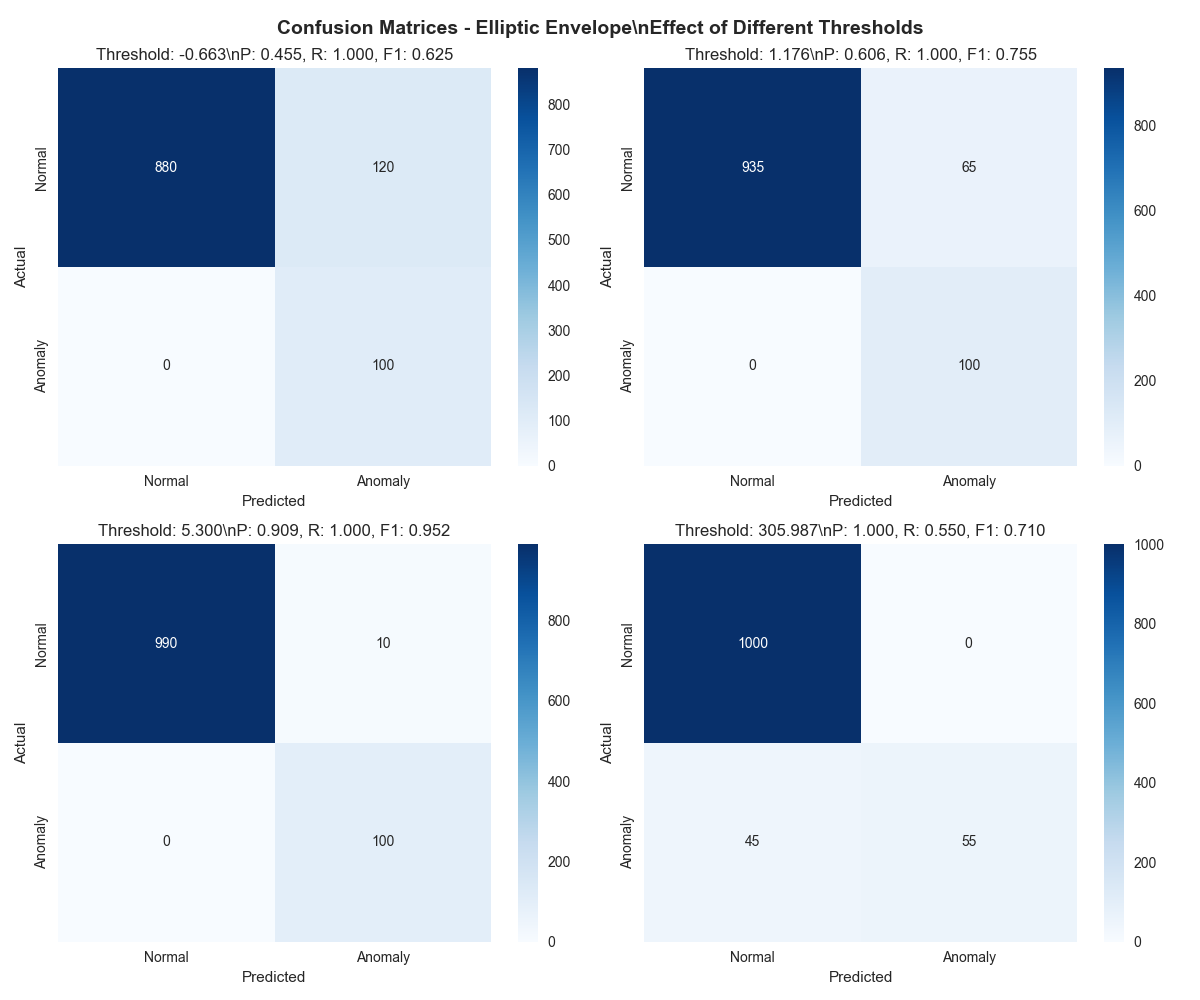

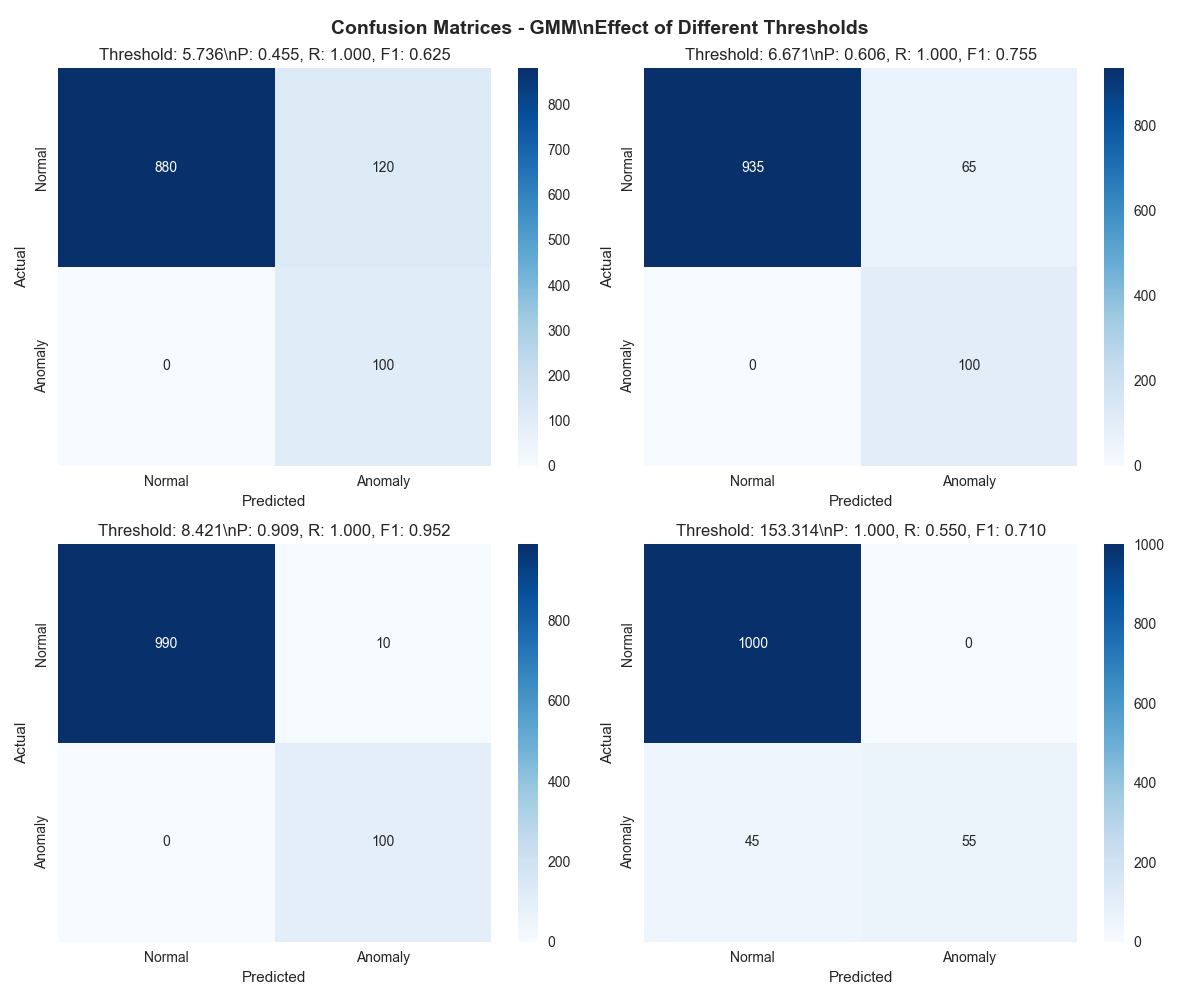

In [10]:
# Visualize confusion matrices for different thresholds
def plot_confusion_matrices_by_threshold(model_name, scores, y_true, selected_thresholds=None):
    """Plot confusion matrices for different thresholds"""
    
    if selected_thresholds is None:
        # Select 4 representative thresholds
        selected_thresholds = np.percentile(scores, [80, 85, 90, 95])
    
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))
    axes = axes.ravel()
    
    for i, threshold in enumerate(selected_thresholds):
        ax = axes[i]
        
        # Make predictions
        y_pred = (scores > threshold).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Normal', 'Anomaly'],
                   yticklabels=['Normal', 'Anomaly'])
        
        ax.set_title(f'Threshold: {threshold:.3f}\\n'
                    f'P: {precision:.3f}, R: {recall:.3f}, F1: {f1:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.suptitle(f'Confusion Matrices - {model_name}\\nEffect of Different Thresholds', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for the best performing models
print("CONFUSION MATRICES FOR DIFFERENT THRESHOLDS")
print("=" * 60)

# Select top 2 models based on best F1-score
model_performance = {}
for model_name, results_df in threshold_results.items():
    model_performance[model_name] = results_df['f1_score'].max()

# Sort models by performance
sorted_models = sorted(model_performance.items(), key=lambda x: x[1], reverse=True)
top_models = [name for name, _ in sorted_models[:2]]

print(f"Showing confusion matrices for top 2 models: {', '.join(top_models)}\\n")

for model_name in top_models:
    scores = anomaly_scores[model_name]
    plot_confusion_matrices_by_threshold(model_name, scores, y_test)

COMPREHENSIVE PERFORMANCE SUMMARY


,Model,Best_F1,F1_Threshold,F1_Precision,F1_Recall,Best_Precision,Best_Recall,Avg_F1
2,Elliptic Envelope,0.952,5.300,0.909,1.00,1.0,1.0,0.592
4,GMM,0.952,8.421,0.909,1.00,1.0,1.0,0.592
5,KDE,0.952,7.467,0.909,1.00,1.0,1.0,0.592
6,Multivariate Gaussian,0.952,8.342,0.909,1.00,1.0,1.0,0.592
1,One-Class SVM,0.943,2.098,0.900,0.99,1.0,1.0,0.591
3,LOF,0.943,0.275,0.900,0.99,1.0,1.0,0.591
0,Isolation Forest,0.829,0.053,0.791,0.87,1.0,1.0,0.568


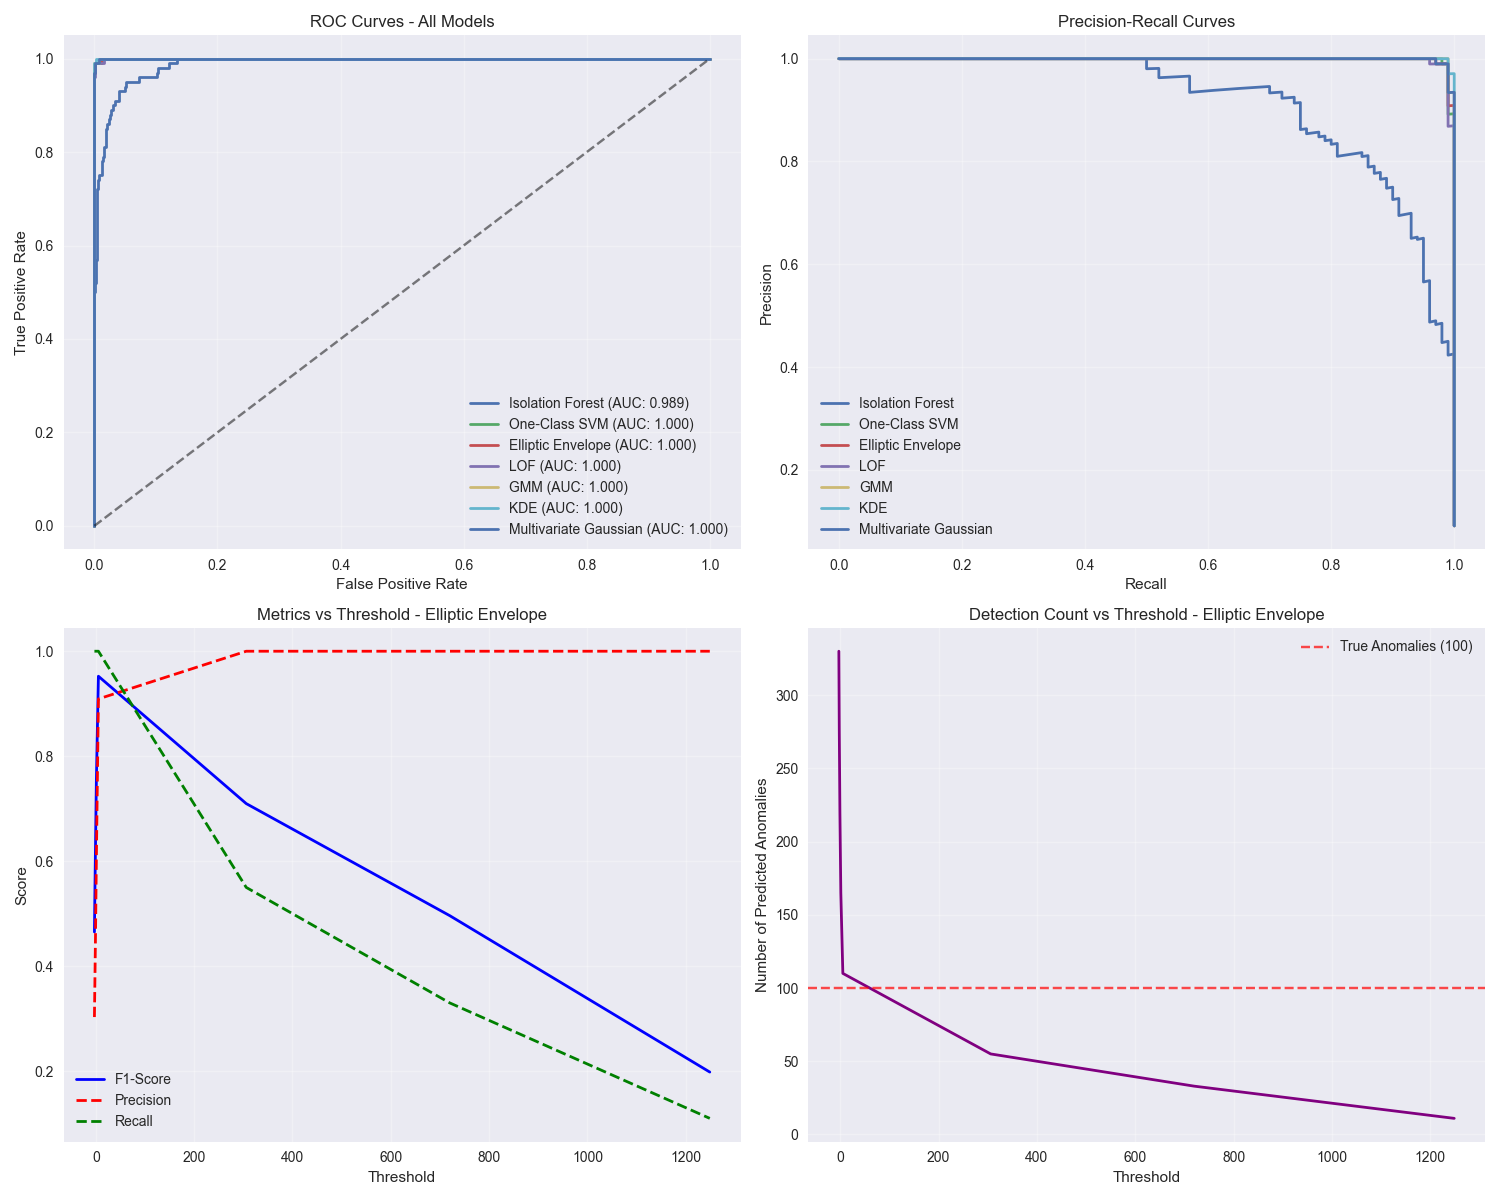

\n🏆 BEST PERFORMING MODEL: Elliptic Envelope
   Best F1-Score: 0.952
   Optimal Threshold: 5.300
   Precision: 0.909
   Recall: 1.000


In [11]:
# Performance comparison across all models and thresholds
def create_performance_summary(threshold_results):
    """Create a comprehensive performance summary"""
    
    summary = []
    
    for model_name, results_df in threshold_results.items():
        # Find best threshold for each metric
        best_f1_idx = results_df['f1_score'].idxmax()
        best_precision_idx = results_df['precision'].idxmax()
        best_recall_idx = results_df['recall'].idxmax()
        
        summary.append({
            'Model': model_name,
            'Best_F1': results_df.loc[best_f1_idx, 'f1_score'],
            'F1_Threshold': results_df.loc[best_f1_idx, 'threshold'],
            'F1_Precision': results_df.loc[best_f1_idx, 'precision'],
            'F1_Recall': results_df.loc[best_f1_idx, 'recall'],
            'Best_Precision': results_df.loc[best_precision_idx, 'precision'],
            'Best_Recall': results_df.loc[best_recall_idx, 'recall'],
            'Avg_F1': results_df['f1_score'].mean()
        })
    
    return pd.DataFrame(summary).sort_values('Best_F1', ascending=False)

# Create performance summary
performance_summary = create_performance_summary(threshold_results)

print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("=" * 70)
display(performance_summary.round(3))

# Plot ROC curves for all models
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 6))

# ROC Curves
for model_name, scores in anomaly_scores.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_score = roc_auc_score(y_test, scores)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC: {auc_score:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - All Models')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
for model_name, scores in anomaly_scores.items():
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, scores)
    ax2.plot(recall_vals, precision_vals, label=model_name, linewidth=2)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# F1-Score vs Threshold for best model
best_model_name = performance_summary.iloc[0]['Model']
best_results = threshold_results[best_model_name]

ax3.plot(best_results['threshold'], best_results['f1_score'], 'b-', linewidth=2, label='F1-Score')
ax3.plot(best_results['threshold'], best_results['precision'], 'r--', linewidth=2, label='Precision')
ax3.plot(best_results['threshold'], best_results['recall'], 'g--', linewidth=2, label='Recall')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title(f'Metrics vs Threshold - {best_model_name}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Number of detected anomalies vs threshold
ax4.plot(best_results['threshold'], best_results['n_predicted_anomalies'], 'purple', linewidth=2)
ax4.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='True Anomalies (100)')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Number of Predicted Anomalies')
ax4.set_title(f'Detection Count vs Threshold - {best_model_name}')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   Best F1-Score: {performance_summary.iloc[0]['Best_F1']:.3f}")
print(f"   Optimal Threshold: {performance_summary.iloc[0]['F1_Threshold']:.3f}")
print(f"   Precision: {performance_summary.iloc[0]['F1_Precision']:.3f}")
print(f"   Recall: {performance_summary.iloc[0]['F1_Recall']:.3f}")

## 7. Interactive Threshold Explorer

Let's create an interactive tool to explore how different thresholds affect the confusion matrix and performance metrics for different models.

In [12]:
def interactive_threshold_explorer(model_name='Isolation Forest', threshold_selection='90th percentile'):
    """Interactive exploration of thresholds and their impact on confusion matrices"""
    
    # Get scores for selected model
    scores = anomaly_scores[model_name]
    
    # Parse threshold selection
    if 'percentile' in threshold_selection:
        percentile = float(threshold_selection.split('th')[0])
        threshold = np.percentile(scores, percentile)
        threshold_label = f"{percentile}th percentile"
    elif 'Custom' in threshold_selection:
        # For custom threshold, use median as default
        threshold = np.median(scores)
        threshold_label = "Custom (median)"
    else:
        # Parse specific threshold values
        threshold = float(threshold_selection.split(':')[1].strip())
        threshold_label = f"Fixed value: {threshold:.3f}"
    
    # Make predictions
    y_pred = (scores > threshold).astype(int)
    
    # Calculate confusion matrix and metrics
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))
    
    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
               xticklabels=['Normal', 'Anomaly'],
               yticklabels=['Normal', 'Anomaly'])
    ax1.set_title(f'Confusion Matrix\nThreshold: {threshold:.4f} ({threshold_label})')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. Metrics Bar Chart
    metrics = ['Precision', 'Recall', 'F1-Score']
    values = [precision, recall, f1]
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars = ax2.bar(metrics, values, color=colors, edgecolor='black', linewidth=1)
    ax2.set_ylim(0, 1)
    ax2.set_title('Performance Metrics')
    ax2.set_ylabel('Score')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Score Distribution with Threshold
    normal_scores = scores[y_test == 0]
    anomaly_scores_subset = scores[y_test == 1]
    
    ax3.hist(normal_scores, bins=30, alpha=0.7, label='Normal', color='blue', density=True)
    ax3.hist(anomaly_scores_subset, bins=20, alpha=0.7, label='Anomalies', color='red', density=True)
    ax3.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    ax3.set_xlabel('Anomaly Score')
    ax3.set_ylabel('Density')
    ax3.set_title(f'Score Distribution - {model_name}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Detailed Breakdown
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        breakdown_labels = ['True Negative\\n(Normal→Normal)', 'False Positive\\n(Normal→Anomaly)', 
                           'False Negative\\n(Anomaly→Normal)', 'True Positive\\n(Anomaly→Anomaly)']
        breakdown_values = [tn, fp, fn, tp]
        breakdown_colors = ['lightblue', 'orange', 'red', 'green']
        
        wedges, texts, autotexts = ax4.pie(breakdown_values, labels=breakdown_labels, colors=breakdown_colors,
                                          autopct='%1.0f', startangle=90, textprops={'fontsize': 9})
        ax4.set_title('Prediction Breakdown')
    
    plt.suptitle(f'{model_name} - Interactive Threshold Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"DETAILED ANALYSIS - {model_name}")
    print("=" * 50)
    print(f"Threshold Value: {threshold:.4f} ({threshold_label})")
    print(f"Total Samples: {len(y_test)}")
    print(f"Predicted Anomalies: {np.sum(y_pred)} / {len(y_test)} ({np.sum(y_pred)/len(y_test)*100:.1f}%)")
    print(f"Actual Anomalies: {np.sum(y_test)} / {len(y_test)} ({np.sum(y_test)/len(y_test)*100:.1f}%)")
    print()
    print("CONFUSION MATRIX BREAKDOWN:")
    if cm.shape == (2, 2):
        print(f"  True Negatives (TN):  {tn:3d} - Correctly identified normal samples")
        print(f"  False Positives (FP): {fp:3d} - Normal samples flagged as anomalies")
        print(f"  False Negatives (FN): {fn:3d} - Missed anomalies (dangerous!)")
        print(f"  True Positives (TP):  {tp:3d} - Correctly detected anomalies")
    print()
    print("PERFORMANCE METRICS:")
    print(f"  Precision: {precision:.3f} - Of predicted anomalies, {precision*100:.1f}% were actually anomalies")
    print(f"  Recall:    {recall:.3f} - Detected {recall*100:.1f}% of actual anomalies")
    print(f"  F1-Score:  {f1:.3f} - Harmonic mean of precision and recall")
    
    if cm.shape == (2, 2):
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        print(f"  False Positive Rate: {fpr:.3f} - {fpr*100:.1f}% of normal samples incorrectly flagged")

# Create comprehensive threshold options for each model
def get_threshold_options(model_name):
    """Get comprehensive threshold options for a specific model"""
    scores = anomaly_scores[model_name]
    
    options = [
        "70th percentile",
        "75th percentile", 
        "80th percentile",
        "85th percentile",
        "90th percentile",
        "95th percentile",
        "97th percentile",
        "99th percentile"
    ]
    
    # Add some specific threshold values based on score distribution
    percentiles = [70, 75, 80, 85, 90, 95, 97, 99]
    threshold_values = [np.percentile(scores, p) for p in percentiles]
    
    # Add quartiles and extremes
    quartiles = [
        f"Min value: {scores.min():.4f}",
        f"25th percentile: {np.percentile(scores, 25):.4f}",
        f"Median: {np.median(scores):.4f}",
        f"75th percentile: {np.percentile(scores, 75):.4f}",
        f"Max value: {scores.max():.4f}"
    ]
    
    # Combine all options
    all_options = options + quartiles
    
    return all_options

# Create interactive widget with listbox for threshold selection
model_options = list(anomaly_scores.keys())

print("🎮 INTERACTIVE THRESHOLD EXPLORER")
print("=" * 50)
print("Select a model and threshold to see real-time confusion matrix updates!")
print("Different threshold strategies:")
print("  📊 Percentiles: Based on score distribution")
print("  📈 Quartiles: Statistical distribution points") 
print("  🎯 Extremes: Minimum and maximum values")
print()

interact(interactive_threshold_explorer,
         model_name=widgets.Dropdown(options=model_options, 
                                    value=model_options[0], 
                                    description='Model:'),
         threshold_selection=widgets.Select(
             options=get_threshold_options(model_options[0]),
             value="90th percentile",
             description='Threshold:',
             disabled=False,
             rows=8,
             layout=widgets.Layout(width='300px')
         ));

🎮 INTERACTIVE THRESHOLD EXPLORER
Select a model and threshold to see real-time confusion matrix updates!
Different threshold strategies:
  📊 Percentiles: Based on score distribution
  📈 Quartiles: Statistical distribution points
  🎯 Extremes: Minimum and maximum values



interactive(children=(Dropdown(description='Model:', options=('Isolation Forest', 'One-Class SVM', 'Elliptic E…

## 🎯 Key Takeaways and Industrial Applications

### **Threshold Selection Strategy:**
- **High Threshold (95th+ percentile)**: Few false alarms, but may miss subtle anomalies
- **Medium Threshold (85-90th percentile)**: Balanced precision/recall for most applications  
- **Low Threshold (70-80th percentile)**: High sensitivity, more false alarms but catches all issues

### **Model Performance Insights:**
- **Isolation Forest**: Excellent for high-dimensional data, handles mixed anomaly types well
- **One-Class SVM**: Good for complex decision boundaries, sensitive to parameter tuning
- **LOF**: Excellent for local anomalies, sensitive to density variations
- **GMM**: Works well when normal data has multiple operational modes
- **Elliptic Envelope**: Fast and simple, assumes Gaussian distribution
- **KDE**: Non-parametric, flexible, but computationally intensive
- **Multivariate Gaussian**: Simple probabilistic model, assumes single Gaussian distribution

### **Industrial Applications:**
- **🏭 Predictive Maintenance**: Early detection of equipment degradation
- **⚙️ Process Monitoring**: Identify deviations from normal operating conditions
- **🔍 Quality Control**: Detect defective products in manufacturing lines
- **🚨 Safety Systems**: Real-time anomaly detection for critical processes
- **📊 Performance Optimization**: Identify sub-optimal operating conditions

### **Confusion Matrix Interpretation in Industrial Context:**
- **True Negatives (TN)**: Normal operation correctly identified ✅
- **False Positives (FP)**: Unnecessary alarms/shutdowns 💸
- **False Negatives (FN)**: Missed failures (potentially dangerous!) ⚠️
- **True Positives (TP)**: Successful anomaly detection 🎯

### **Threshold Optimization Guidelines:**
1. **Safety-Critical Systems**: Prioritize recall (minimize false negatives)
2. **Cost-Sensitive Operations**: Balance precision and recall based on costs
3. **High-Volume Production**: Optimize for minimal false positives to avoid disruptions
4. **Research/Development**: Use lower thresholds for comprehensive anomaly discovery

---

**This tutorial demonstrates how to build robust anomaly detection systems for industrial applications with proper threshold optimization and evaluation strategies.**